# Atividade 01 - Modelagem dinâmica e cinemática de robôs móveis de tração diferencial

Defina um cenário de teste e implemente computacionalmente os modelos dinâmicos desenvolvidos no artigo.

In [66]:
import numpy as np

def draw_robot(x, y, theta, ax, scale=1.0, **kwargs):
    """
    Desenha o contorno do robô no gráfico fornecido.
    
    Parâmetros:
    x, y  : Posição do centro do robô (m)
    theta : Orientação do robô (rad)
    ax    : Objeto Axes do matplotlib onde o robô será desenhado
    scale : Escala do desenho (para ajustar o tamanho visualmente)
    **kwargs: Argumentos opcionais de plotagem (ex: color='b', linestyle='--')
    """
    
    # Definição dos pontos do polígono (Formato aproximado do Pioneer P3DX)
    # Matriz 12x3 baseada na sua função original
    p = np.zeros((12, 3))
    
    # X local, Y local, Z (fator de escala inverso homogêneo)
    p[:] = [
        [ 1,    1/7,  1/scale],
        [-3/7,  1,    1/scale],
        [-5/7,  6/7,  1/scale],
        [-5/7,  5/7,  1/scale],
        [-3/7,  2/7,  1/scale],
        [-3/7,  0,    1/scale],
        [-3/7, -2/7,  1/scale],
        [-5/7, -5/7,  1/scale],
        [-5/7, -6/7,  1/scale],
        [-3/7, -1,    1/scale],
        [ 1,   -1/7,  1/scale],
        [ 1,    1/7,  1/scale]
    ]
    
    # Aplica o fator de escala (coluna 3 vira 1, colunas 1 e 2 escalam)
    p = scale * p
    
    # Matriz de Transformação Homogênea (Rotação + Translação)
    # A lógica original usava um produto vetorial específico (Nx3) . (3x2)
    r = np.array([
        [np.cos(theta),  np.sin(theta)],
        [-np.sin(theta), np.cos(theta)],
        [x,              y]
    ])
    
    # Transforma os pontos para o referencial global
    # Resultado é uma matriz (12x2) contendo X e Y globais
    p_transf = np.dot(p, r)
    
    X_plot = p_transf[:, 0]
    Y_plot = p_transf[:, 1]
    
    # Define cor padrão se não for passada
    if 'color' not in kwargs and 'c' not in kwargs:
        kwargs['color'] = 'blue'
        
    # Plota no eixo fornecido
    ax.plot(X_plot, Y_plot, **kwargs)

## Configuring the Environment - run once

In [67]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import os

# Parameters of Pioneer 3DX
Ra = 0.71      # Ohm
La = 0.00066   # H
Kb = 0.023     # V·s/rad
Kt = 0.029     # N·m/A
N = 38.3       # gear ratio

R = 0.1        # m (wheel radius)
L = 0.19       # m (half the wheelbase)
d = 0.05       # m (CoM offset)
mw = 1.0       # kg (wheel + actuator mass)
mc = 7.0       # kg (chassis mass)
Im = 0.0025    # kg·m²
Ir = 0.005     # kg·m²
Ic = 1.0       # kg·m²

m = mc + 2 * mw
I = Ic + mc * d**2 + 2 * mw * L**2 + 2 * Im

# Initialize the Remote API
client = RemoteAPIClient()
sim = client.require('sim')

# Open the P3DX scene 
simulation_file = os.getcwd()+'/p3dx_dynamic_model.ttt'
sim.loadScene(simulation_file)

# Use the stepping mode
sim.setStepping(True)


0

In [131]:
# Configure the handles
PioneerP3DX = sim.getObjectHandle('/PioneerP3DX')
leftMotor = sim.getObjectHandle('/PioneerP3DX/leftMotor')
rightMotor = sim.getObjectHandle('/PioneerP3DX/rightMotor')

# Capture the initial pose from simulation
initial_P3DXPos=sim.getObjectPosition(PioneerP3DX,-1)
initial_P3DXOri=sim.getObjectOrientation(PioneerP3DX,-1)

# Configure the time vectors
execution_time = 10
dt = sim.getSimulationTimeStep()
t_points = np.arange(0, execution_time, dt)
t_span = (0, execution_time)

# Configure the motors voltage input
vaD = -3.0  # V
vaE = -3.0  # V

## DDMR Mathematical Model 

In [132]:
def M_bar():
    m11 = Ir + (R**2 / (4 * L**2)) * (m * L**2 + I)
    m12 = (R**2 / (4 * L**2)) * (m * L**2 - I)
    M = np.array([[m11, m12], [m12, m11]])
    return M

def V_bar(theta_dot):
    v = (R**2 / (4 * L**2)) * (mc * d * theta_dot)
    return np.array([[0, v], [-v, 0]])

B_bar = np.eye(2)

#  Voltage input (constant)
def voltage_input(t):
    return np.array([vaD, vaE])

# State vector: [iaD, iaE, phid, phie, phid_dot, phie_dot] 
def dynamics(t, x):
    iaD, iaE, phid, phie, phid_dot, phie_dot, theta, x_pos, y_pos = x
    va = voltage_input(t)
    
    # Electrical subsystem
    diaD = (va[0] - Kb * N * phid_dot - Ra * iaD) / La
    diaE = (va[1] - Kb * N * phie_dot - Ra * iaE) / La
    
    # Motor torques with N gear
    tau = Kt * N * np.array([iaD, iaE])
    
    # Dynamic Model -> Calculate the wheels velocities (phiddot)
    M = M_bar()
    theta_dot = (R / (2 * L)) * (phid_dot - phie_dot)
    V = V_bar(theta_dot)
    phiddot = np.linalg.inv(M) @ (-V @ np.array([phid_dot, phie_dot]) + B_bar @ tau)

    # Kinematic Model -> Calculate the robot pose
    # \dot{x}_a = (R/2) * (\dot{\phi}_R + \dot{\phi}_L) * cos(\theta)
    x_pos_dot = (R / 2) * (phid_dot + phie_dot) * np.cos(theta)
    
    # \dot{y}_a = (R/2) * (\dot{\phi}_R + \dot{\phi}_L) * sin(\theta)
    y_pos_dot = (R / 2) * (phid_dot + phie_dot) * np.sin(theta)

    return [diaD, diaE, phid_dot, phie_dot, phiddot[0], phiddot[1], theta_dot, x_pos_dot, y_pos_dot]


## Executing the Dynamic Model Simulation

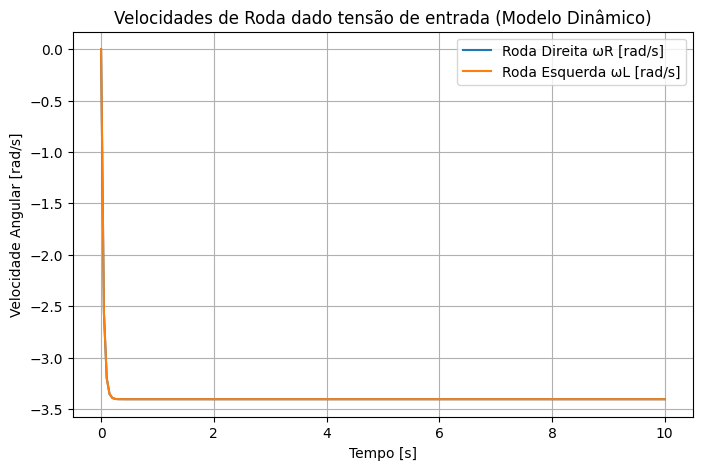

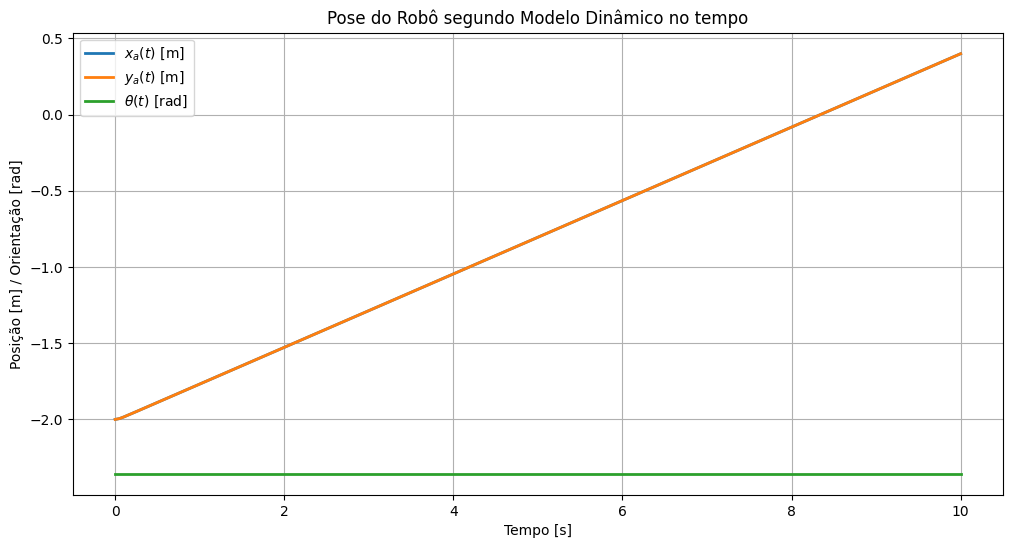

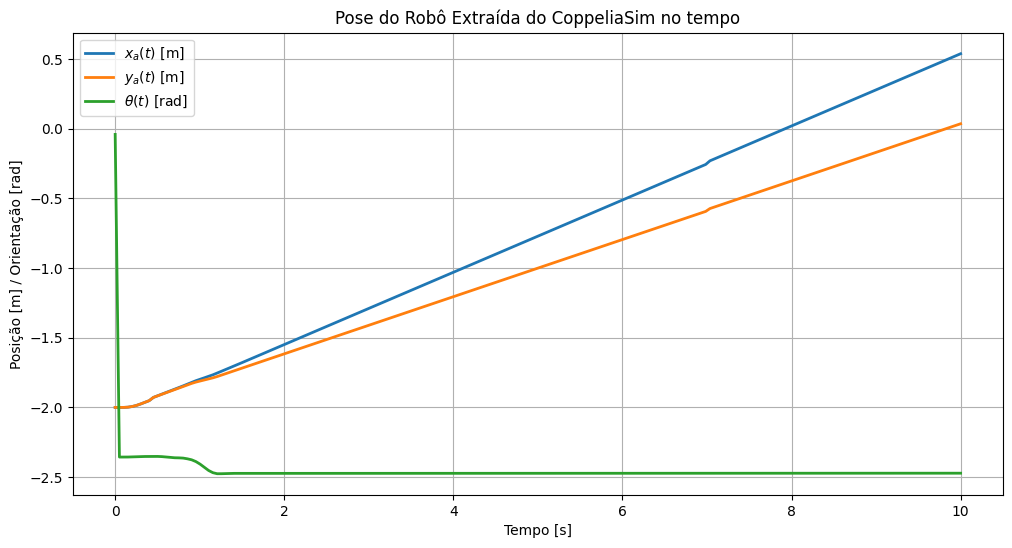

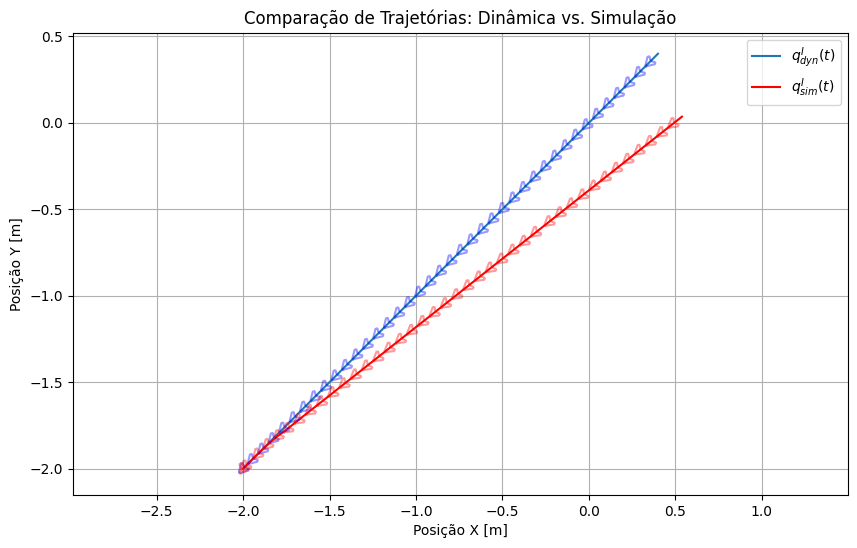

In [ ]:
x0 = np.array([0,0,0,0,0,0,initial_P3DXOri[2],initial_P3DXPos[0],initial_P3DXPos[1]])
sol = solve_ivp(dynamics, t_span, x0, t_eval=np.linspace(*t_span, int(execution_time/dt)))

leftVel = sol.y[5]
rightVel = sol.y[4]

poses_coppelia = np.array([initial_P3DXPos[0], initial_P3DXPos[1], initial_P3DXOri[2]])

# Start the simulation on CoppeliaSim
sim.startSimulation()

for k in range(len(t_points)-1):

    # get robot pose
    P3DXPos=sim.getObjectPosition(PioneerP3DX,-1)
    P3DXOri=sim.getObjectOrientation(PioneerP3DX,-1)

    # save in the pose vector for future plot
    pose_sim = np.array([P3DXPos[0], P3DXPos[1], P3DXOri[2]*(180/np.pi)])
    poses_coppelia = np.vstack((poses_coppelia, pose_sim))

    # set wheel velocities    
    sim.setJointTargetVelocity(leftMotor,leftVel[k])
    sim.setJointTargetVelocity(rightMotor,rightVel[k])

    #print(f'Simulation time: {sim.getSimulationTime():.2f} [s]', leftVel[k], rightVel[k])
    sim.step()
sim.stopSimulation()

# --- Plot results ---
plt.figure(figsize=(8,5))
plt.plot(sol.t, sol.y[4], label='Roda Direita ωR [rad/s]')
plt.plot(sol.t, sol.y[5], label='Roda Esquerda ωL [rad/s]')
plt.xlabel('Tempo [s]')
plt.ylabel('Velocidade Angular [rad/s]')
plt.legend()
plt.title(f'Velocidades de Roda dado tensão de entrada (Modelo Dinâmico)')
plt.grid()
plt.show()

# Plot robot pose in time from dyn
plt.figure(figsize=(12, 6))
plt.plot(sol.t, sol.y[7], label='$x_a(t)$ [m]', lw=2)
plt.plot(sol.t, sol.y[8], label='$y_a(t)$ [m]', lw=2)
plt.plot(sol.t, sol.y[6], label='$\\theta(t)$ [rad]', lw=2)
plt.xlabel('Tempo [s]')
plt.ylabel('Posição [m] / Orientação [rad]')
plt.title('Pose do Robô segundo Modelo Dinâmico no tempo')
plt.legend()
plt.grid(True)
plt.show()

# Plot robot pose in time from Coppelia
plt.figure(figsize=(12, 6))
plt.plot(sol.t, poses_coppelia[:,0] , label='$x_a(t)$ [m]', lw=2)
plt.plot(sol.t, poses_coppelia[:,1], label='$y_a(t)$ [m]', lw=2)
plt.plot(sol.t, poses_coppelia[:,2]*(np.pi/180), label='$\\theta(t)$ [rad]', lw=2)
plt.xlabel('Tempo [s]')
plt.ylabel('Posição [m] / Orientação [rad]')
plt.title('Pose do Robô Extraída do CoppeliaSim no tempo')
plt.legend()
plt.grid(True)
plt.show()

# P# Plot robot pose in X and Y
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sol.y[7], sol.y[8], label='$q^I_{dyn}(t)$', lw=1.5)
ax.plot(poses_coppelia[:,0], poses_coppelia[:,1], label='$q^I_{sim}(t)$', lw=1.5, color ='red')
step = 5 
scale = 0.03 

for i in range(0, len(sol.y[7])-1, step):
    draw_robot(sol.y[7][i], sol.y[8][i], sol.y[6][i], ax, scale=scale, color='blue', alpha=0.4)
    
    draw_robot(poses_coppelia[:,0][i], poses_coppelia[:,1][i], poses_coppelia[:,2][i]*(np.pi/180), ax, scale=scale, color='red', alpha=0.4)

ax.set_title('Comparação de Trajetórias: Dinâmica vs. Simulação')
ax.set_xlabel('Posição X [m]')
ax.set_ylabel('Posição Y [m]')
ax.axis('equal')
ax.grid(True)
ax.legend()
plt.show()